<a href="https://colab.research.google.com/github/CaptainJimbo/MyPortfolio/blob/main/Solving_The_Three_Body_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table align="left">
  <td align="left">
  <a target="_blank" href="https://dimitriskogias.wixsite.com/spacecowboy" style="text-decoration: none; display: flex; align-items: center; color: white; background-color: purple; padding: 10px; border-radius: 5px;">
      <img src="https://static.wikia.nocookie.net/bravestarr/images/6/6d/Lucas_Conway.png/revision/latest?cb=20211111224054" width="40px" height="40px" style="border-radius: 50%; margin-right: 10px;" />
      <span>Visit my Webpage</span>
    </a>
  </td>
</table>



<table align="left">
  <td align="left"><a target="_blank" href="https://github.com/CaptainJimbo/MyPortfolio/blob/main/Solving_The_Three_Body_Problem.ipynb" style="text-decoration: none; display: flex; align-items: center; color: black; background-color: lightgray; padding: 10px; border-radius: 5px;">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  width="40px" height="40px" style="border-radius: 50%; margin-right: 10px;"   />View it on GitHub</a></td>
</table>


In [1]:
# Load libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import time

# Datasets
#!wget https://dl.dropboxusercontent.com/s/p5u9w3v8nctjdut/Breen_NN_project2.h5
#!wget https://dl.dropboxusercontent.com/s/mjcuk5t2i1nrpoc/data_project2.npz

!wget https://dl.dropboxusercontent.com/s/p5u9w3v8nctjdut/Breen_NN_project2.h5 -O Breen_NN_project2.h5
!wget https://dl.dropboxusercontent.com/s/mjcuk5t2i1nrpoc/data_project2.npz -O data_project2.npz


--2023-07-09 18:16:41--  https://dl.dropboxusercontent.com/s/p5u9w3v8nctjdut/Breen_NN_project2.h5
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.6.15, 2620:100:601c:15::a27d:60f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.6.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1870184 (1.8M) [text/plain]
Saving to: ‘Breen_NN_project2.h5’

Breen_NN_project2.h 100%[===================>]   1.78M  --.-KB/s    in 0.01s   

2023-07-09 18:16:41 (147 MB/s) - ‘Breen_NN_project2.h5’ saved [1870184/1870184]

--2023-07-09 18:16:42--  https://dl.dropboxusercontent.com/s/mjcuk5t2i1nrpoc/data_project2.npz
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.6.15, 2620:100:601c:15::a27d:60f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.6.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519093502 (495M) [application/octet-stream]
Saving to: ‘

In [2]:
# functions

def get_data(idx):
    x = np. array([data[idx,:,0],data[idx,:,3],data[idx,:,4]]).T   #t,x2,y2 shape=(time steps,3)
    y = np.array([data[idx,:,1],data[idx,:,2],data[idx,:,3],data[idx,:,4]]).T  #x1,y1,x2,y2 shape=(time steps,4)
    return x,y

def get_training_data(idx):
    data = training_data
    x = np. array([data[idx,:,0],data[idx,:,3],data[idx,:,4]]).T   #t,x2,y2 shape=(time steps,3)
    y = np.array([data[idx,:,1],data[idx,:,2],data[idx,:,3],data[idx,:,4]]).T  #x1,y1,x2,y2 shape=(time steps,4)
    return x,y

def get_trajectories(pred):
    # pred = x1,y1,x2,y2
    p1 = np. array([pred[:,0],pred[:,1]]).T
    p2 = np. array([pred[:,2],pred[:,3]]).T
    p3 = -p1 -p2  # x1 + x2 + x3 = 0 , y1 + y2 + y3 = 0
    return p1,p2,p3

def plot_trajectories(p1, p2, p3, ax=None, style = '-', leg = None, **kwargs):
    plt.plot(p1[:,0],p1[:,1],'r',linestyle = style , label = leg)
    plt.plot(p1[0,0],p1[0,1],'ro')
    plt.plot(p2[:,0],p2[:,1],'b',linestyle = style , label = leg)
    plt.plot(p2[0,0],p2[0,1],'bo')
    plt.plot(p3[:,0],p3[:,1],'g',linestyle = style , label = leg)
    plt.plot(p3[0,0],p3[0,1],'go') # bullets for initial conditions

    plt.legend(loc='best',fontsize='small');
    #return NotImplementedError #wtfisthis

def special_input(data,idx):
    t = data[idx,:,0]
    x2 = data[idx,:,3]*0 + data[idx,:,3][0] # 1000 element columns with the same initial position)
    y2 = data[idx,:,4]*0 + data[idx,:,4][0] # from get data function[0]= t,x2,y2
    return np.array([t,x2,y2]).T


In [3]:
# Load and unpack the compressed npy array
load_data = np.load('data_project2.npz')
data = load_data['arr_0']
print(f'data.shape={data.shape}')
print(f'this guy has {data.shape[0]} samples of {data.shape[2]} columns of (t,x1,y1,x2,y2,ux1,uy1,ux2,uy2) and each one has {data.shape[1]} elements')

data.shape=(9000, 1000, 9)
this guy has 9000 samples of 9 columns of (t,x1,y1,x2,y2,ux1,uy1,ux2,uy2) and each one has 1000 elements


In [4]:
# lets load the pre trained model and predict some trajectories
pre_trained_model = keras.models.load_model("Breen_NN_project2.h5")

In [5]:
from sklearn.model_selection import train_test_split

#sample splitting
train_percentage = 0.9
training_data, validation_data = train_test_split(data ,train_size=train_percentage)
size = len(training_data)
input_data_unshaped = np.zeros(((size,1000,3)))# still (t,x2,y2)

# this special_input  fucntion that changes x2,y2 snapshots to x2_0,y2_0 everywhere
for idx in range(size):
    input_data_unshaped [idx] = special_input(training_data,idx)

# input data reshaping
train_input_data = input_data_unshaped.reshape(-1,3)
print(f'The training sample is the {train_percentage*100}% of data and has size {size}.\n \
\n\n - The shape of the unshaped input training sample is {input_data_unshaped.shape}, that is {size} samples of \
1000 snapshots of (t , x2(t)=x2_0 , y2(t)=y2_0). In order to have a valid training input we stack all samples \
by column and that changes the input training sample shape to {train_input_data.shape}.')

output_data_unshaped = training_data[:,:,:5][:,:,1:]
train_output_data = output_data_unshaped.reshape(-1,4)
print (f'\n - The shape of the unshaped output training sample is {output_data_unshaped.shape}. In order to have a\
 valid training output we stack all samples by column and that changes the output training sample \
shape to {train_output_data.shape}.')



val_percentage = 0.1
size = len(validation_data)
input_data_unshaped = np.zeros(((size,1000,3)))# still (t,x2,y2)

# this special_input  fucntion that changes x2,y2 snapshots to x2_0,y2_0 everywhere
for idx in range(size):
    input_data_unshaped [idx] = special_input(validation_data,idx)

# input data reshaping
val_input_data = input_data_unshaped.reshape(-1,3)
print(f'\n\n\nThe validation sample is the {val_percentage*100}% of data and has size  {size}.\n \
\n\n - The shape of the unshaped input validation sample is {input_data_unshaped.shape}, that is {size} samples of \
1000 snapshots of (t , x2(t)=x2_0 , y2(t)=y2_0). In order to have a valid validation input we stack all samples \
by column and that changes the input validation sample shape to {val_input_data.shape}.')

output_data_unshaped = validation_data[:,:,:5][:,:,1:]
val_output_data = output_data_unshaped.reshape(-1,4)
print (f'\n - The shape of the unshaped output validation sample is {output_data_unshaped.shape}. In order to have a\
 valid validation output we stack all samples by column and that changes the output validation sample \
shape to {val_output_data.shape}.')






The training sample is the 90.0% of data and has size 8100.
 

 - The shape of the unshaped input training sample is (8100, 1000, 3), that is 8100 samples of 1000 snapshots of (t , x2(t)=x2_0 , y2(t)=y2_0). In order to have a valid training input we stack all samples by column and that changes the input training sample shape to (8100000, 3).

 - The shape of the unshaped output training sample is (8100, 1000, 4). In order to have a valid training output we stack all samples by column and that changes the output training sample shape to (8100000, 4).



The validation sample is the 10.0% of data and has size  900.
 

 - The shape of the unshaped input validation sample is (900, 1000, 3), that is 900 samples of 1000 snapshots of (t , x2(t)=x2_0 , y2(t)=y2_0). In order to have a valid validation input we stack all samples by column and that changes the input validation sample shape to (900000, 3).

 - The shape of the unshaped output validation sample is (900, 1000, 4). In order to have a

In [6]:
print(f' Recap: \n')
print(f' train_input_data.shape = {train_input_data.shape}\n train_output_data.shape = {train_output_data.shape} \n \
val_input_data.shape = {val_input_data.shape}\n val_output_data.shape = {val_output_data.shape} ')

 Recap: 

 train_input_data.shape = (8100000, 3)
 train_output_data.shape = (8100000, 4) 
 val_input_data.shape = (900000, 3)
 val_output_data.shape = (900000, 4) 


In [7]:
# creating the data_sets

# my inputs/outputs have dimensions (8100000,3)/(8100000,4)
training_dataset = tf.data.Dataset.from_tensor_slices((train_input_data,train_output_data))

# my inputs/outputs have dimensions (900000,3)/(900000,4)
validation_dataset =  tf.data.Dataset.from_tensor_slices((val_input_data,val_output_data))

# batches of 5 samples (5*1000)
training_dataset = training_dataset.batch(5000)
validation_dataset = validation_dataset.batch(5000)


In [11]:
# my Neural Network
myNN = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3)),  #input
    tf.keras.layers.Dense(128, activation='relu'), #1
    tf.keras.layers.Dense(128, activation='relu'), #2
    tf.keras.layers.Dense(128, activation='relu'), #3
    tf.keras.layers.Dense(128, activation='relu'), #4
    tf.keras.layers.Dense(128, activation='relu'), #5
    tf.keras.layers.Dense(128, activation='relu'), #6
    tf.keras.layers.Dense(128, activation='relu'), #7
    tf.keras.layers.Dense(128, activation='relu'), #8
    tf.keras.layers.Dense(128, activation='relu'), #9
    tf.keras.layers.Dense(128, activation='relu'), #10
    tf.keras.layers.Dense(4)                      #output
])

# summary
myNN.summary()

# compiler
myNN.compile(optimizer=keras.optimizers.Adam(0.001, 0.5, 0.5)
              ,loss=keras.losses.MeanAbsoluteError(),
              metrics=['mse'])



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 128)               512       
                                                                 
 dense_23 (Dense)            (None, 128)               16512     
                                                                 
 dense_24 (Dense)            (None, 128)               16512     
                                                                 
 dense_25 (Dense)            (None, 128)               16512     
                                                                 
 dense_26 (Dense)            (None, 128)               16512     
                                                                 
 dense_27 (Dense)            (None, 128)               16512     
                                                                 
 dense_28 (Dense)            (None, 128)              

In [13]:
#training of myNN

start =  time.perf_counter()
end = time.perf_counter()
result = myNN.fit_generator(training_dataset, epochs=10, validation_data = validation_dataset) # epochs=100
# This best runs for 100 epochs with loss ~ 0.07 and takes ~ 230 minutes, if you want to wait.
total_time = end - start
print(f'total time is {round(total_time/60)} minutes')

Epoch 1/10


<ipython-input-13-e25ff07499b0>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  result = myNN.fit_generator(training_dataset, epochs=10, validation_data = validation_dataset) # epochs=100


1620/1620 [==============================] - 139s 85ms/step - loss: 0.2089 - mse: 0.1644 - val_loss: 0.1793 - val_mse: 0.1295
Epoch 2/10
1620/1620 [==============================] - 140s 86ms/step - loss: 0.1536 - mse: 0.1164 - val_loss: 0.1408 - val_mse: 0.1082
Epoch 3/10
1620/1620 [==============================] - 138s 85ms/step - loss: 0.1394 - mse: 0.1050 - val_loss: 0.1372 - val_mse: 0.0938
Epoch 4/10
1620/1620 [==============================] - 138s 85ms/step - loss: 0.1308 - mse: 0.0988 - val_loss: 0.1264 - val_mse: 0.0993
Epoch 5/10
1620/1620 [==============================] - 138s 85ms/step - loss: 0.1260 - mse: 0.0962 - val_loss: 0.1156 - val_mse: 0.0841
Epoch 6/10
1620/1620 [==============================] - 138s 85ms/step - loss: 0.1195 - mse: 0.0913 - val_loss: 0.1076 - val_mse: 0.0697
Epoch 7/10
1620/1620 [==============================] - 137s 85ms/step - loss: 0.1161 - mse: 0.0900 - val_loss: 0.1370 - val_mse: 0.1143
Epoch 8/10
1620/1620 [==============================

In [ ]:
#result.history

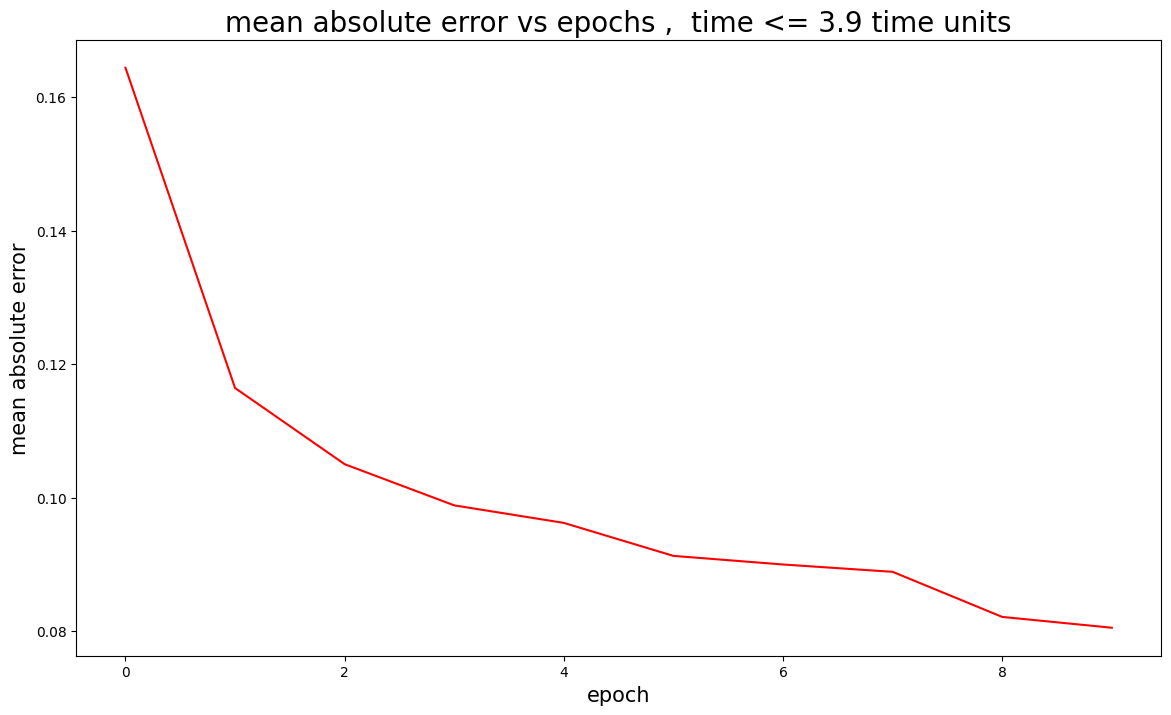

In [14]:
# plotting mae vs epoch
result.history['mse']
plt.figure(figsize=(14,8))
plt.title('mean absolute error vs epochs ,  time <= 3.9 time units' ,size=20)
plt.plot(result.history['mse'],'r');
plt.xlabel('epoch',size=15)
plt.ylabel('mean absolute error',size=15);


32/32 [==============================] - 0s 1ms/step
             myNN                       pretrained

 [[ 5.8366698e-01  8.6186323e-03  1.0018935e+00 -7.0858747e-04]
 [ 9.9018723e-01  5.0502829e-03  1.0019546e+00 -6.9790334e-04]
 [ 9.8265249e-01 -3.5589393e-03  1.0020087e+00 -6.8504363e-04]
 ...
 [-1.2416854e+00  9.1091126e-01 -7.0749921e-01  6.9077402e-01]
 [-1.2414696e+00  9.1117209e-01 -7.0709032e-01  6.9014758e-01]
 [-1.2419212e+00  9.1156048e-01 -7.0696658e-01  6.8962395e-01]]


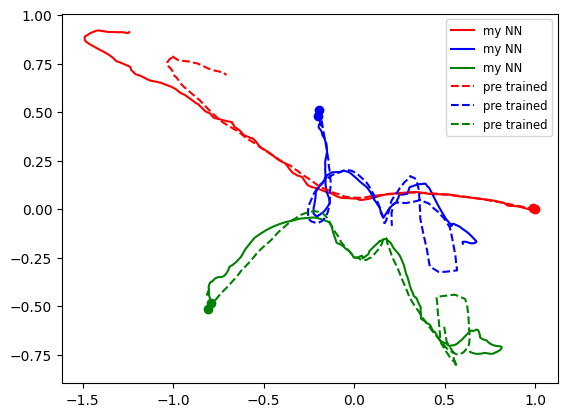

In [15]:
# Lets compare my NN with the pre trained model from the paper

# i pick a random initial condition
idxrand = np.random.randint(9000)

# prediction for my NN nad plotting
predictions = myNN.predict( special_input(data, idxrand))
r1 , r2, r3 = get_trajectories(predictions)
# i discarded the first points of x1,y1,x2,y2, the x1,y1(0) was not (1,0) the x1,y1(1) was fine about (1,0)
plot_trajectories(r1[1:,:] , r2[1:,:] , r3[1:,:], ax=None , leg = 'my NN')
k1 = r1
# prediction for pre trained model and plotting
predictions = pre_trained_model.predict( special_input(data, idxrand))
r1 , r2 , r3 = get_trajectories(predictions)
plot_trajectories(r1, r2, r3, ax=None, style='--',leg = 'pre trained')
print(f'             myNN                       pretrained\n\n {np.hstack((k1,r1))}')

32/32 [==============================] - 0s 1ms/step
             predicted                       original

 [[ 1.00189352e+00 -7.08587468e-04  1.00000000e+00  0.00000000e+00]
 [ 1.00195456e+00 -6.97903335e-04  9.99993765e-01  1.19823636e-06]
 [ 1.00200868e+00 -6.85043633e-04  9.99975060e-01  4.79296263e-06]
 ...
 [-7.07499206e-01  6.90774024e-01 -7.19373332e-01  6.65102040e-01]
 [-7.07090318e-01  6.90147579e-01 -7.16962651e-01  6.63806848e-01]
 [-7.06966579e-01  6.89623952e-01 -7.14539399e-01  6.62501035e-01]]


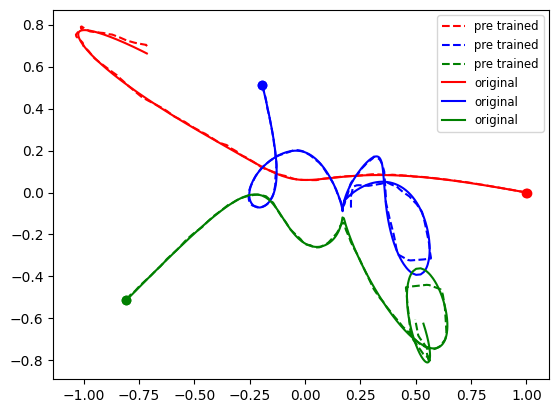

In [16]:
predictions = pre_trained_model.predict( special_input(data, idxrand))
r1 , r2 , r3 = get_trajectories(predictions)
plot_trajectories(r1, r2, r3, ax=None, style ='--',leg = 'pre trained')
k1 = r1
r1 , r2 , r3 = get_trajectories(get_data(idxrand)[1])
plot_trajectories(r1, r2, r3, ax=None, style ='-', leg = 'original')
print(f'             predicted                       original\n\n {np.hstack((k1,r1))}')



In [21]:
print('Comment: One can easily observe that, the machine learning model trained through neural networks, accurately mirrors the original trajectories.')

Comment: One can easily observe that, the machine learning model trained through neural networks, accurately mirrors the original trajectories.


In [17]:
#from datetime import datetime
#now = datetime.now()
#current_datetime = now.strftime("%D,%H-%M-%S")
#name = 'myNN_mk2('+current_datetime+').h5'

# saving model
tf.keras.models.save_model(myNN, 'myNN_10_128.h5')